In [1]:
import os
import pickle
import time
import numpy as np
import pandas as pd
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, recall_score, classification_report
from sklearn.metrics import precision_recall_fscore_support as score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError
from utils.preprocess import *
from utils.feature_engineering import *
from utils.nn import *
from utils.plot_nn_training import *

In [2]:
print(tf.__version__)

# we need to set up gpus for tensorflow-gpu and cudnn
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)

tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
warnings.filterwarnings("ignore")

# Download, read in, preprocess data

## Loading data

In [4]:
model_prefix = ''
days = 7
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=True)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=True)
    labeled_data.to_csv()

Reading csv


In [5]:
# read in data, extract data and labels
labeled_data = preprocess(labeled_data)
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

In [6]:
regions

,,danger_level_1,danger_level_2,danger_level_3,danger_level_4,danger_level_5,danger_level_6,emergency_warning_1,emergency_warning_2,emergency_warning_3,emergency_warning_4,...,regobs_snowprofile_t_min_4_4,regobs_snowprofile_t_min_4_5,regobs_snowprofile_t_min_4_6,regobs_snowprofile_t_min_4_7,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7
region,date,,,,,,,,,,,,,,,,,,,,,
3003,2017-12-07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,2017-12-07,3.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3009,2017-12-07,3.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3010,2017-12-07,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3011,2017-12-07,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3032,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2021-01-12,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


One of the first things we need to take care of is the precipitation column. There are some extremely high values throughout the dataset that we need to drop.

In [7]:
precip_cols = [col for col in regions.columns if 'precip' in col and 'exposed' not in col]
regions_precip = regions.loc[:, precip_cols]

There is a set of anomalously high precipitation values in this dataset that we need to be mindful of.

In [8]:
precip_outliers = np.where(regions_precip > 100)[0]

In [9]:
drop_idx = regions.index[precip_outliers]
regions = regions.drop(drop_idx)

In [10]:
regions.loc[:, precip_cols].max()

precip_0    95.6
precip_1    95.6
precip_2    95.6
precip_3    95.6
precip_4    95.6
precip_5    95.6
dtype: float64

These seem like more reasonable values. We need to do the same thing for the labels, though.

In [11]:
labels = labels.drop(drop_idx)

In [12]:
print('Shape of input data:  {}'.format(regions.shape))
print('Shape of labels    :  {}'.format(labels.shape))

Shape of input data:  (12519, 6516)
Shape of labels    :  (12519, 69)


In [13]:
# encode cause and aspect columns in labels
labels = encode_causes(labels)
labels = encode_aspects(labels)

## Feature Engineering

In a previous Notebook analysis on the importance of different features, we say that different meteorological variables from RegObs are often more important than other fields included in the data. And what's more, combining variables to create custom features is even *more* important. We can create those features again below.

In [14]:
# drop wind speed columns
wind_dir_cols = [col for col in regions.columns if 'wind_dir' in col]
#regions.drop(wind_dir_cols, axis=1, inplace=True)

# create 72 hour sum or max of wind speed, precip, and max temp
wind_speed_cols = [col for col in regions.columns if 'wind' in col and 'speed' in col]
regions = wind_speed_max(regions, wind_speed_cols)
to_sum = ['wind_speed_max_0', 'wind_speed_max_1', 'wind_speed_max_2']
regions = sum_over_features(regions, to_sum, 'wind_speed_72hr')

to_sum = ['precip_0', 'precip_1', 'precip_2']
regions = sum_over_features(regions, to_sum, 'precip_72hr')

to_sum = ['temp_max_0', 'temp_max_1', 'temp_max_2']
regions = take_max(regions, to_sum, 'temp_max_72hr')

We could include all of our important data below with the following code:

```python
dont_include_list = ['acc', 'dir', 'fl_start', 'regobs', 'start']
to_include = [col for col in regions.columns]

for drop_col in dont_include_list:
    to_include = [col for col in to_include if drop_col not in col]

train = regions.loc[:, to_include]
train
```

But a single model works better using just weather data.

In [15]:
dont_include_list = ['acc', 'dir', 'fl_start', 'regobs', 'start']
to_include = [col for col in regions.columns if 'precip' in col or 'temp' in col or 'wind' in col]

for drop_col in dont_include_list:
    to_include = [col for col in to_include if drop_col not in col]
    
train = regions.loc[:, to_include]
train

,,precip_most_exposed_0,precip_most_exposed_1,precip_most_exposed_2,precip_most_exposed_3,precip_most_exposed_4,precip_most_exposed_5,precip_0,precip_1,precip_2,precip_3,...,temp_freeze_lev_5,wind_speed_max_0,wind_speed_max_1,wind_speed_max_2,wind_speed_max_3,wind_speed_max_4,wind_speed_max_5,wind_speed_72hr,precip_72hr,temp_max_72hr
region,date,,,,,,,,,,,,,,,,,,,,,
3003,2017-12-07,8.0,4.0,4.0,8.0,10.0,5.0,1.0,0.0,0.0,0.0,...,0.000,15.5,9.0,9.0,0.0,9.0,9.0,33.5,1.0,-8.0
3007,2017-12-07,1.4,7.5,0.1,6.8,16.0,5.2,1.4,6.2,0.0,5.5,...,237.510,12.0,9.0,5.5,9.0,9.0,12.0,26.5,7.6,-5.9
3009,2017-12-07,1.8,9.0,7.6,6.4,13.0,4.4,1.5,8.0,6.2,5.4,...,267.920,15.5,5.5,9.0,9.0,9.0,9.0,30.0,15.7,-6.5
3010,2017-12-07,0.2,9.7,13.5,10.2,9.2,2.9,0.1,9.2,12.2,9.0,...,326.270,15.5,5.5,12.0,12.0,9.0,9.0,33.0,21.5,-6.2
3011,2017-12-07,0.1,10.3,15.0,13.5,9.5,3.8,0.1,9.8,14.2,11.6,...,210.565,12.0,5.5,5.5,9.0,9.0,9.0,23.0,24.1,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.0,10.0,15.0,20.0,2.0,0.0,0.0,5.0,10.0,15.0,...,0.000,9.0,5.5,5.5,15.5,0.0,0.0,20.0,15.0,-5.0
3032,2021-01-12,0.0,2.0,6.0,5.0,0.0,0.0,0.0,0.0,3.0,2.0,...,0.000,12.0,5.5,9.0,12.0,0.0,0.0,26.5,3.0,-9.0
3034,2021-01-12,2.0,8.0,20.0,20.0,0.0,0.0,0.0,4.0,12.0,10.0,...,0.000,9.0,5.5,9.0,12.0,5.5,5.5,23.5,16.0,-7.0


### Scale data

In [16]:
scaled_X = scale_input_data(train.values)
train = pd.DataFrame(scaled_X, columns=train.columns, index=train.index)

In [17]:
# could use CLASS_danger_level or CLASS_problem_1
train_labels = labels.loc[:, ['CLASS_danger_level']]
train_labels

,,CLASS_danger_level
region,date,
3003,2017-12-07,2
3007,2017-12-07,2
3009,2017-12-07,2
3010,2017-12-07,3
3011,2017-12-07,3
...,...,...
3031,2021-01-12,3
3032,2021-01-12,3
3034,2021-01-12,3


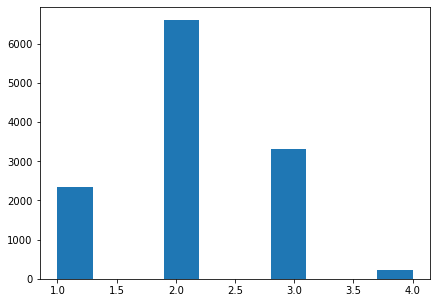

In [18]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(train_labels, align='mid',)
plt.show()

### Single Class Detection

We could try to isolate one class vs the others and see how a neural network does at predicting a specific danger level.

In [19]:
train_labels[train_labels.values == 1] = 0
train_labels[train_labels.values == 2] = 0
train_labels[train_labels.values == 3] = 1
train_labels[train_labels.values == 4] = 0

print(np.unique(train_labels.values))

[0 1]


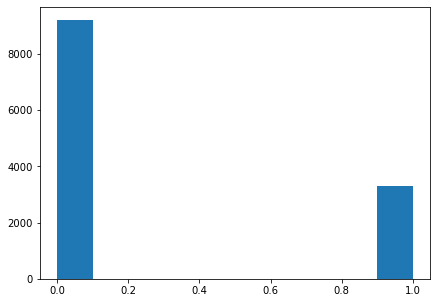

In [20]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(train_labels.values, align='mid',)
plt.show()

In [21]:
class_occurrences = (train_labels.value_counts() / len(train_labels) * 100).sort_index()
round(class_occurrences, 2)

CLASS_danger_level
0                     73.52
1                     26.48
dtype: float64

Scikit-learn makes it easy to calculate class weights for imbalanced classification tasks. Note: this can act as another form of regularization for the model.

In [22]:
flat_values = [value[0] for value in train_labels.values]
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(flat_values),
                                            flat_values)

print(weights)

[0.68008475 1.88823529]


In [23]:
weights = {
    0: 0.68,
    1: 1.89,
}

weights

{0: 0.68, 1: 1.89}

Lastly, we can include the danger level in the input data. When we batch and window the data, this means that we can use danger level from the past week to predict tomorrow's danger level.

In [24]:
train['danger_level'] = train_labels
train

,,precip_most_exposed_0,precip_most_exposed_1,precip_most_exposed_2,precip_most_exposed_3,precip_most_exposed_4,precip_most_exposed_5,precip_0,precip_1,precip_2,precip_3,...,wind_speed_max_0,wind_speed_max_1,wind_speed_max_2,wind_speed_max_3,wind_speed_max_4,wind_speed_max_5,wind_speed_72hr,precip_72hr,temp_max_72hr,danger_level
region,date,,,,,,,,,,,,,,,,,,,,,
3003,2017-12-07,0.067170,0.033585,0.033585,0.067170,0.083963,0.041982,0.010460,0.000000,0.000000,0.000000,...,0.516667,0.300000,0.300000,0.000000,0.300000,0.300000,0.403614,0.006545,0.371942,0
3007,2017-12-07,0.011755,0.062972,0.000840,0.057095,0.134341,0.043661,0.014644,0.064854,0.000000,0.057531,...,0.400000,0.300000,0.183333,0.300000,0.300000,0.400000,0.319277,0.049744,0.418220,0
3009,2017-12-07,0.015113,0.075567,0.063812,0.053736,0.109152,0.036944,0.015690,0.083682,0.064854,0.056485,...,0.516667,0.183333,0.300000,0.300000,0.300000,0.300000,0.361446,0.102760,0.404998,0
3010,2017-12-07,0.001679,0.081444,0.113350,0.085642,0.077246,0.024349,0.001046,0.096234,0.127615,0.094142,...,0.516667,0.183333,0.400000,0.400000,0.300000,0.300000,0.397590,0.140722,0.411609,1
3011,2017-12-07,0.000840,0.086482,0.125945,0.113350,0.079765,0.031906,0.001046,0.102510,0.148536,0.121339,...,0.400000,0.183333,0.183333,0.300000,0.300000,0.300000,0.277108,0.157740,0.504165,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.000000,0.083963,0.125945,0.167926,0.016793,0.000000,0.000000,0.052301,0.104603,0.156904,...,0.300000,0.183333,0.183333,0.516667,0.000000,0.000000,0.240964,0.098178,0.438054,1
3032,2021-01-12,0.000000,0.016793,0.050378,0.041982,0.000000,0.000000,0.000000,0.000000,0.031381,0.020921,...,0.400000,0.183333,0.300000,0.400000,0.000000,0.000000,0.319277,0.019636,0.349905,1
3034,2021-01-12,0.016793,0.067170,0.167926,0.167926,0.000000,0.000000,0.000000,0.041841,0.125523,0.104603,...,0.300000,0.183333,0.300000,0.400000,0.183333,0.183333,0.283133,0.104724,0.393979,1


# Split data

In [25]:
train_idx = [3007, 3012, 3010, 3009, 3013, 3017, 3014, 3032, 
             3027, 3029, 3022, 3031, 3023, 3037, 3024, 3028]
val_idx =   [3011, 3016, 3035]
test_idx =  [3006, 3015, 3034]

X_train = [train.loc[idx].values for idx in train_idx]
y_train = [train_labels.loc[idx].values for idx in train_idx]

X_val = [train.loc[idx].values for idx in val_idx]
y_val = [train_labels.loc[idx].values for idx in val_idx]

X_test = [train.loc[idx].values for idx in test_idx]
y_test = [train_labels.loc[idx].values for idx in test_idx]

In [26]:
sequence_length = 7 # this is an arbitrary choice, a hyperparameter
X_train_pad = [pad_sequence(arr, sequence_length) for arr in X_train]
y_train_pad = [pad_sequence(arr, sequence_length) for arr in y_train]

X_val_pad = [pad_sequence(arr, sequence_length) for arr in X_val]
y_val_pad = [pad_sequence(arr, sequence_length) for arr in y_val]

X_test_pad = [pad_sequence(arr, sequence_length) for arr in X_test]
y_test_pad = [pad_sequence(arr, sequence_length) for arr in y_test]

In [27]:
# reshape data into (samples, timesteps, features)
X_concat_train = np.concatenate(X_train_pad)
y_concat_train = np.concatenate(y_train_pad)

X_concat_val = np.concatenate(X_val_pad)
y_concat_val = np.concatenate(y_val_pad)

X_concat_test = np.concatenate(X_test_pad)
y_concat_test = np.concatenate(y_test_pad)

print(X_concat_train.shape)
print(y_concat_train.shape)
print(X_concat_val.shape)
print(y_concat_val.shape)
print(X_concat_test.shape)
print(y_concat_test.shape)

(8939, 58)
(8939, 1)
(1722, 58)
(1722, 1)
(1302, 58)
(1302, 1)


In order to use the recall metric, you need to have your vector of binary values one-hot encoded as a 2D matrix. We can do that below.

In [28]:
encoder = OneHotEncoder()
y_concat_train = encoder.fit_transform(y_concat_train).toarray()
y_concat_val = encoder.fit_transform(y_concat_val).toarray()
y_concat_test = encoder.fit_transform(y_concat_test).toarray()

In [29]:
batchX_train, batchY_train = batch_data(X_concat_train, y_concat_train, sequence_length)
batchX_val, batchY_val = batch_data(X_concat_val, y_concat_val, sequence_length)
batchX_test, batchY_test = batch_data(X_concat_test, y_concat_test, sequence_length)

(8932, 7, 58) (8932, 2)
(1715, 7, 58) (1715, 2)
(1295, 7, 58) (1295, 2)


# Training a neural network

## DNN
We can define our neural network below. This is a multiclass classification problem, meaning that we need as many output units in the last layer as there are unique labels in our training set. It also means that we should use a softmax activation in the last layer and some form of categorical crossentropy as the loss function.

In [35]:
# network params
input_neurons = 100
output_neurons = len(np.unique(y_concat_train))
drop = 0.3

# training params
num_epochs = 10000
alpha = 1e-5
batch_size = 256
criterion = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=alpha)

In [36]:
window_dnn = create_dnn(batchX_train, input_neurons, drop, output_neurons)

window_dnn_history = train_binary(window_dnn, batchX_train, batchY_train, 
                           batchX_val, batchY_val, criterion, optimizer, 
                           batch_size, num_epochs, weights)

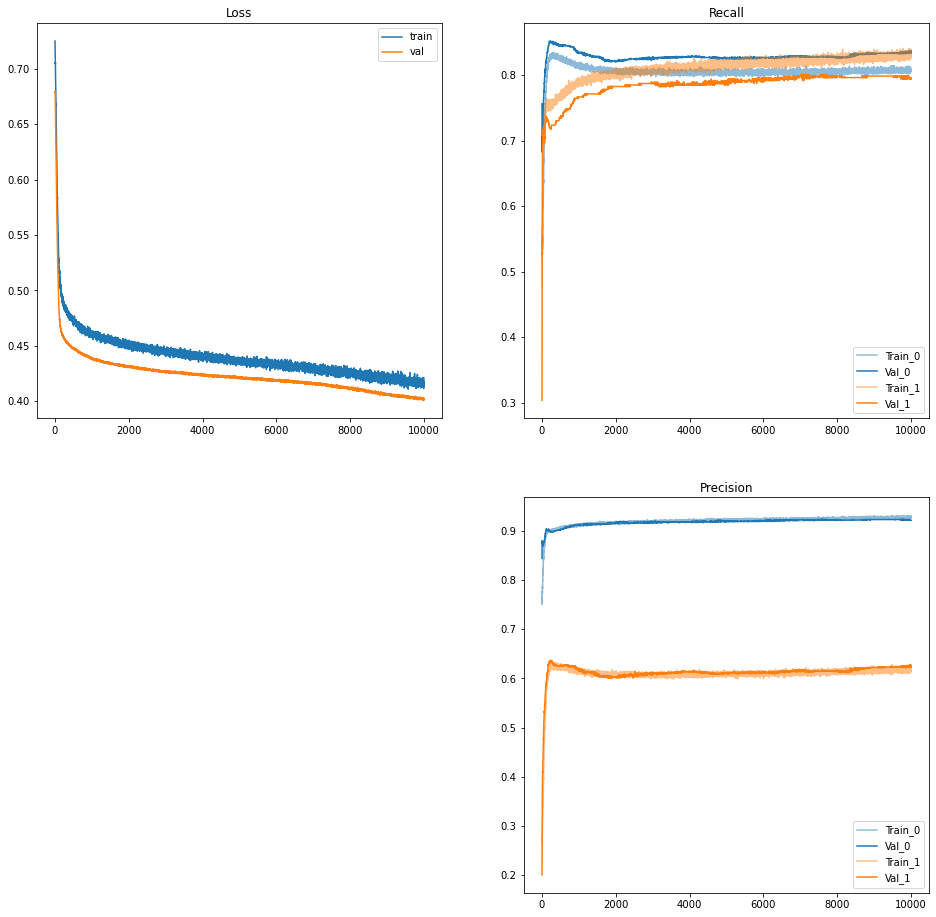

In [37]:
plot_history(window_dnn_history.history)

precision: [0.92121212 0.625     ]
recall:    [0.83516484 0.79365079]
fscore:    [0.87608069 0.6993007 ]


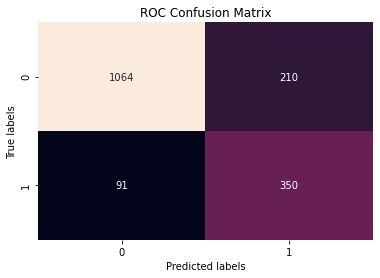

In [38]:
preds = plot_confusion_matrix(window_dnn, batchX_val, np.argmax(batchY_val, axis=1))

And now with regularization?

In [39]:
window_dnn_reg = create_dnn(batchX_train, input_neurons, drop, output_neurons, True)

window_dnn_reg_history = train_binary(window_dnn_reg, batchX_train, batchY_train, 
                               batchX_val, batchY_val, criterion, optimizer, 
                               batch_size, num_epochs, weights)

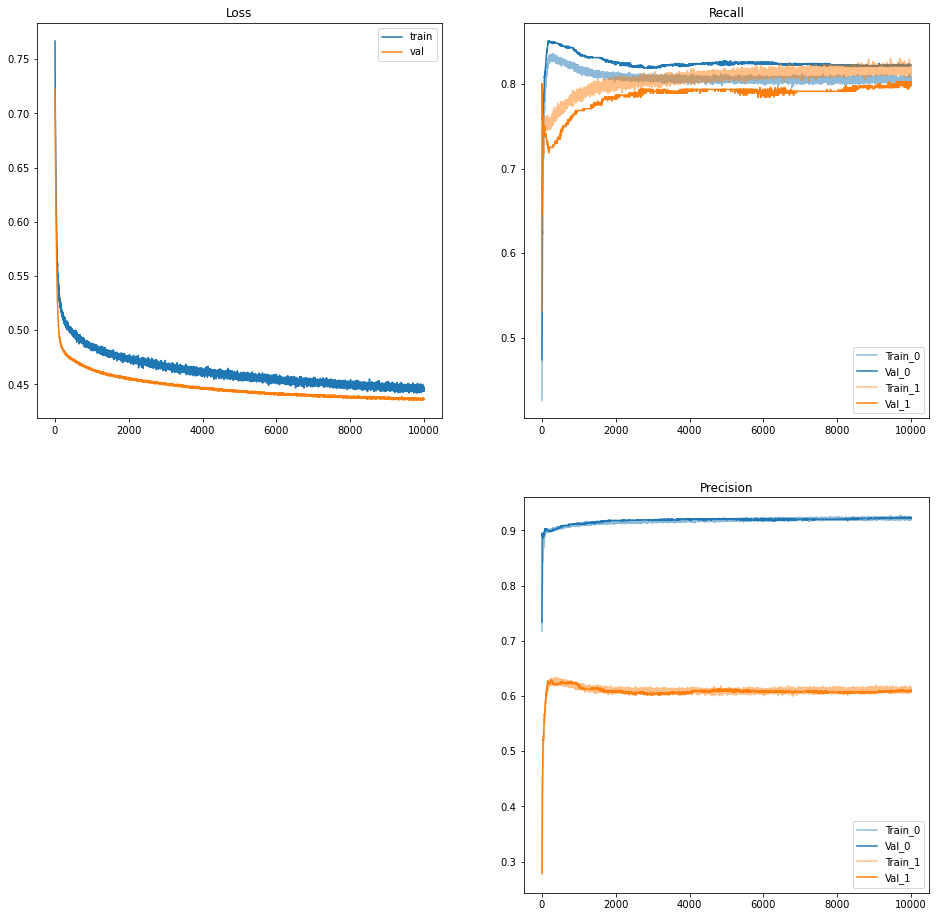

In [40]:
plot_history(window_dnn_reg_history.history)

precision: [0.92334802 0.61034483]
recall:    [0.82260597 0.80272109]
fscore:    [0.87007057 0.69343781]


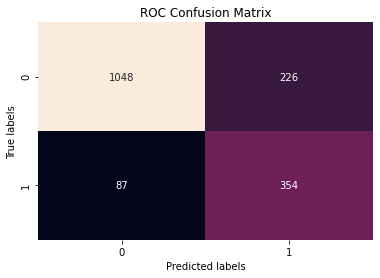

In [41]:
preds = plot_confusion_matrix(window_dnn_reg, batchX_val, np.argmax(batchY_val, axis=1))

This is looking fairly good, but, ideally that bottom left square would be 0 (no false negatives). Additionally, we'd like to see the model perform better at reducing false positives.

## LSTM

We can repeat the same steps as above, but this time with a LSTM to see how that affects performance.

In [42]:
# network params
input_neurons = 8
dense_neurons = 10
drop = 0.3

# training params
num_epochs = 7500
alpha = 1e-5
batch_size = 256

In [43]:
window_rnn = create_rnn(batchX_train, input_neurons, dense_neurons, drop, output_neurons)

window_rnn_history = train_binary(window_rnn, batchX_train, batchY_train, 
                           batchX_val, batchY_val, criterion, optimizer, 
                           batch_size, num_epochs, weights)

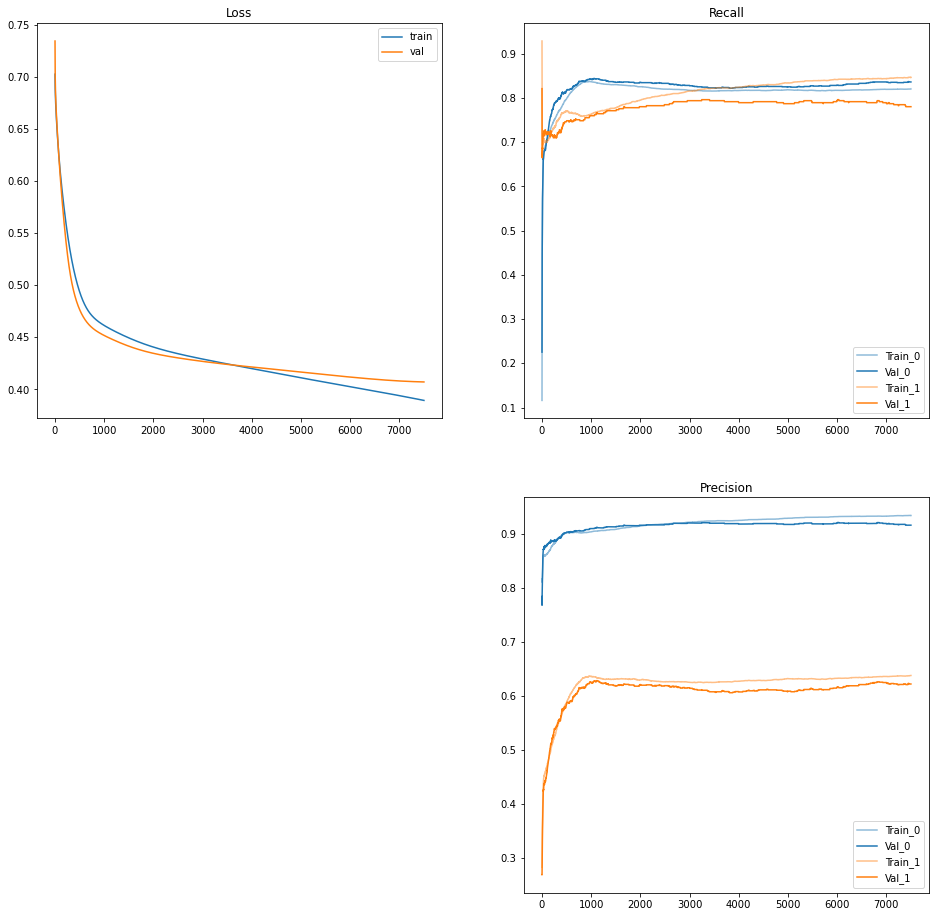

In [44]:
plot_history(window_rnn_history.history)

precision: [0.91652324 0.62206148]
recall:    [0.83594976 0.78004535]
fscore:    [0.87438424 0.69215292]


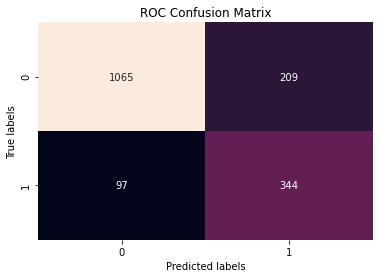

In [45]:
preds = plot_confusion_matrix(window_rnn, batchX_val, np.argmax(batchY_val, axis=1))

In [46]:
window_rnn_reg = create_rnn(batchX_train, input_neurons, dense_neurons, drop, output_neurons, True)

window_rnn_reg_history = train_binary(window_rnn_reg, batchX_train, batchY_train, 
                               batchX_val, batchY_val, criterion, optimizer, 
                               batch_size, num_epochs, weights)

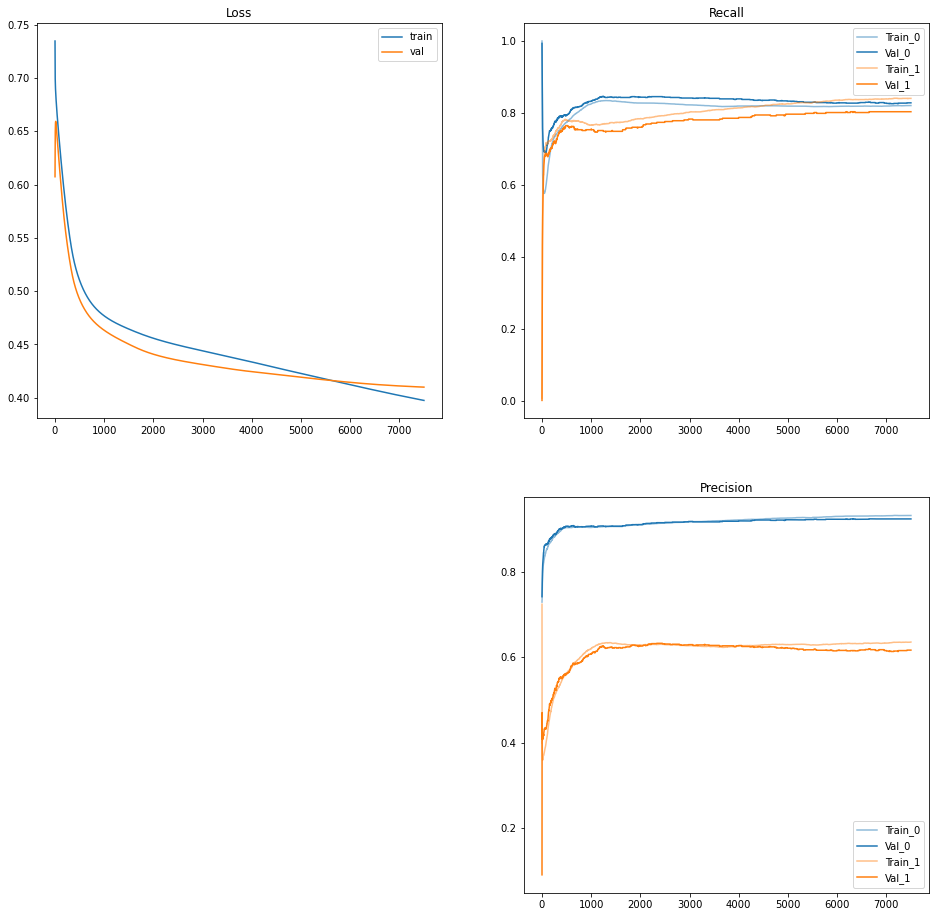

In [47]:
plot_history(window_rnn_reg_history.history)

precision: [0.9237511  0.61672474]
recall:    [0.82731554 0.80272109]
fscore:    [0.87287785 0.69753695]


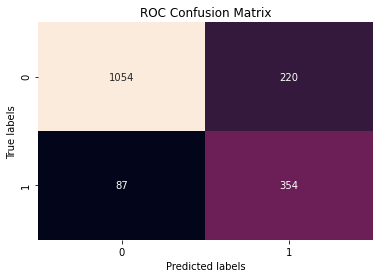

In [48]:
preds = plot_confusion_matrix(window_rnn_reg, batchX_val, np.argmax(batchY_val, axis=1))

# Predicting on the test set

This is relatively easy to set up. Since we have already processed the test set alongside the training and validation sets, it should be ready to go.

We should save the best models so that we can load them later (instead of running the whole Notebook again). Note: we only need to save the models once unless we decide to retrain the them later.

In [49]:
# save best model
# https://www.tensorflow.org/tutorials/keras/save_and_load?hl=en
best_dnn = window_dnn_reg
best_rnn = window_rnn_reg

best_dnn.save('models/dnn_dl_3')
best_rnn.save('models/rnn_dl_3')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/dnn_dl_3/assets
INFO:tensorflow:Assets written to: models/rnn_dl_3/assets


precision: [0.90734055 0.56465517]
recall:    [0.78870293 0.77286136]
fscore:    [0.84387241 0.65255293]


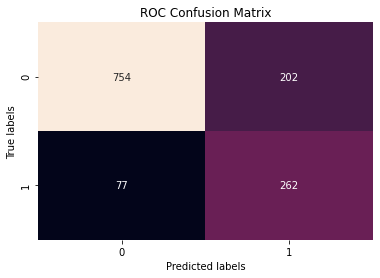

In [50]:
# load saved models
best_dnn = tf.keras.models.load_model('models/dnn_dl_3')
test_preds = plot_confusion_matrix(best_dnn, batchX_test, np.argmax(batchY_test, axis=1))

precision: [0.90963139 0.57929515]
recall:    [0.80020921 0.77581121]
fscore:    [0.85141903 0.66330391]


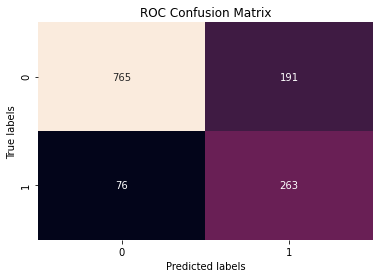

In [51]:
best_rnn = tf.keras.models.load_model('models/rnn_dl_3')
test_preds = plot_confusion_matrix(best_rnn, batchX_test, np.argmax(batchY_test, axis=1))

Okay, so these models perform worse than they do for danger levels 1 and 2. A little bit lower recall, but significantly less precision.